In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='white', palette=sns.color_palette('RdBu'))

import numpy as np 
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection import train_test_split

%matplotlib inline


In [16]:
mat = sio.loadmat('./data/ex8data1.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.294

In [17]:
X = mat.get('X')

Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'), 
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


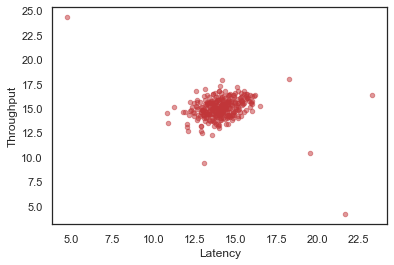

In [18]:
sns.regplot('Latency', 'Throughput', data=pd.DataFrame(X, columns=['Latency', 'Throughput']),
            fit_reg=False,
            scatter_kws={'s': 20, 'alpha': 0.5}
           )
plt.show()

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


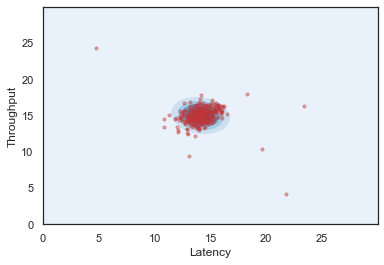

In [45]:
mu = X.mean(axis=0)
cov = np.cov(X.T)   # 计算协方差矩阵

# 创建多元高斯模型
multi_normal = stats.multivariate_normal(mu, cov)

# 创建2d网格
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x,y))  # 相当于做笛卡尔积

fig, ax = plt.subplots()

# 画概率密度
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# 画原始数据点
sns.regplot('Latency', 'Throughput',
            data=pd.DataFrame(X, columns=['Latency', 'Throughput']),
            fit_reg=False,
            ax=ax,
            scatter_kws={'s': 10, 'alpha': 0.4}
           )
plt.show()


In [48]:
from sklearn.metrics import f1_score, classification_report

def select_threshold(X, Xval, yval):
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    
    pval = multi_normal.pdf(Xval)
    
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)
    
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))
        
    argmax_fs = np.argmax(fs)
    
    return epsilon[argmax_fs], fs[argmax_fs]

In [49]:
e, fs = select_threshold(X, Xval, yval)

In [50]:
print(f'Best epsilon: {e}\nBest F-score on validation data: {fs}')

Best epsilon: 3.609512922966843e-05
Best F-score on validation data: 0.8571428571428571


In [52]:
def predict(X, Xval, e, Xtest, ytest):
    Xdata = np.concatenate((X, Xval), axis=0)
    
    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')
    
    print(classification_report(ytest, y_pred))
    
    return multi_normal, y_pred

In [53]:
multi_norml, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00         1

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: regplot() got an unexpected keyword argument 'fig_reg'

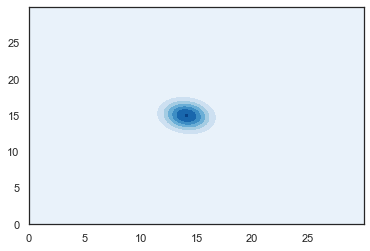

In [54]:
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={'s': 10, 'alpha': 0.4})

anamoly_data = data[data['y_pred'] == 1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], )